# Cryptolytic Arbitrage Model Evaluation and Selection

This notebook contains the code and analysis to select models with the best performance for the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_data_processing.ipynb) and modeling in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_modeling.ipynb).

#### Background on Arbitrage Models
Arbitrage models were created with the goal of predicting arbitrage 10 min before it happens in an active crypto market. The models are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the model have a direction indicating which direction the arbitrage occurs in. A valid arbitrage signal is when the arbitrage lasts >30 mins because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades.

The models predict whether there will be an arbitrage opportunity that starts 10 mins after the prediction time and lasts for at least 30 mins, giving a user enough times to execute trades.

More than 6000+ iterations of models were generated in this notebook and the best ones were selected from each possible arbitrage combination based on model selection criteria outlined later in this section. The models were Random Forest Classifier and the best model parameters varied for each dataset. The data was obtained from the respective exchanges via their api, and we did a 70/30 train/test split on 5 min candlestick data that fell anywhere in the range from Jun 2015 - Oct 2019. There was a 2 week gap left between the train and test sets to prevent data leakage. The models return 0 (no arbitrage), 1 (arbitrage from exchange 1 to exchange 2) and -1 (arbitrage from exchange 2 to exchange 1). 

The profit calculation incorporated fees like in the real world. We used mean percent profit as the profitability metric which represented the average percent profit per arbitrage trade if one were to act on all trades predicted by the model in the testing period, whether those predictions were correct or not.

#### Model Evaluation Criteria
- ROC AUC score
- Precison
- Recall
- F1 Score
- Status
- Profit



#### Model Selection
From the 6000+ iterations of models trained, the best models were narrowed down based on the following criteria:
- How often the models predicted arbitrage when it didn't exist (False positives)
- How many times the models predicted arbitrage correctly (True positives)
- How profitable the model was in the real world over the period of the test set.

#### Results and Discussion

For each of the models, show a dataframe of the LR scores, default RF scores, and hyperparm tuned RF scores.


There were 21 models that met the thresholds for model selection critera (details of these models can be found at the end of this nb). The final models were all profitable with gains anywhere from 0.2% - 2.3% within the varied testing time periods (Note: the model with >9% mean percent profit was an outlier). Visualizations for how these models performed can be viewed at https://github.com/Lambda-School-Labs/cryptolytic-ds/blob/master/finalized_notebooks/visualization/arb_performance_visualization.ipynb


#### Directory Structure

#### Directory Structure
```
├── cryptolytic/                        <-- Root directory   
│   ├── modeling/                       <-- Directory for modeling work
│   │      │
│   │      ├──assets/                   <-- Directory with png assets used in notebooks
│   │      │
│   │      ├──data/                     <-- Directory containing all data for project
│   │      │   ├─ arb_data/             <-- Directory for train data after merging + FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ arb_preds_test_data/  <-- Directory for test data w/ predictions
│   │      │   │   └── *.csv 
│   │      │   │
│   │      │   ├─ arb_top_data/         <-- Directory for data from the best models
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ raw_data/             <-- Directory for raw training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ raw_zip_data/         <-- Directory containing zip files of raw data
│   │      │   │   └── *.zip
│   │      │   │
│   │      │   ├─ all_features.txt      <-- All features used in baseline models
│   │      │   │
│   │      │   ├─ top_features.txt      <-- Most important features for models
│   │      │   │
│   │      │   ├─ model_perf.csv        <-- Data from training baseline models and tuning
│   │      │   │
│   │      │   ├─ top_model_perf.csv    <-- Data from retraining and exporting best models
│   │      │
│   │      ├── models/                  <-- Directory for all pickle models
│   │      │      └── *.pkl
│   │      │
│   │      ├─ 1_arbitrage_data_processing.ipynb  <-- NB for data processing and creating csv
│   │      │
│   │      ├─ 2_arbitrage_modeling.ipynb         <-- NB for baseline models and tuning
│   │      │
│   │      ├─ 3_arbitrage_model_evaluation.ipynb <-- NB for model selection, eval, and viz
│   │      │
│   │      ├─ trade_recommender_models.ipynb     <-- NB for trade recommender models
│   │      │
│   │      ├─ environment.yml                    <-- Contains project dependencies
│   │      │
│   │      ├─ utils.py                           <-- All the functions used in modeling
│   │      │

```

## Imports

In [ ]:
# to update your conda env from a yml file from terminal
# conda env update --file modeling/environment.yml

# to export yml from terminal(will get errors if you run it like this, only work on same builds/OS)
# conda env export > modeling/environment.yml

# this will work with different builds/OS but still had few errors on packages, commented them out in yml file
# conda env export --no-builds > modeling/environment.yml

In [1]:
import glob
import itertools
import json
import os
from pathlib import Path
import pickle
import shutil
from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")
import ast

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.set_option('display.max_rows', 100000)
import seaborn as sns

# from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# # from sklearn.metrics import precision_recall_fscore_support
# # from sklearn.metrics import precision_score, recall_score,  roc_auc_score
# # from sklearn.metrics import accuracy_score, f1_score, 
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import ParameterGrid

# from utils import tbl_stats_headings, print_model_name
# from utils import get_higher_closing_price, get_close_shift, get_profit, profit
# from utils import create_pg
# from utils import model_names
# from utils import ttsplit
# from utils import model_eval
from utils import create_models
# from utils import ALL_FEATURES

## Data

All the arbitrage datasets that will be used in modeling

In [2]:
with open ('data/train_data_paths.txt', 'rb') as fp:
    train_data_paths = pickle.load(fp)
print(len(train_data_paths))
train_data_paths

15


['data/arb_data/bitfinex_cbpro_etc_usd.csv',
 'data/arb_data/cbpro_bitfinex_ltc_usd.csv',
 'data/arb_data/hitbtc_cbpro_eth_usdc.csv',
 'data/arb_data/cbpro_bitfinex_eth_usd.csv',
 'data/arb_data/bitfinex_hitbtc_bch_usdt.csv',
 'data/arb_data/gemini_bitfinex_bch_btc.csv',
 'data/arb_data/gemini_hitbtc_bch_btc.csv',
 'data/arb_data/cbpro_gemini_bch_btc.csv',
 'data/arb_data/kraken_gemini_bch_btc.csv',
 'data/arb_data/bitfinex_cbpro_btc_usd.csv',
 'data/arb_data/gemini_kraken_ltc_btc.csv',
 'data/arb_data/bitfinex_hitbtc_ltc_usdt.csv',
 'data/arb_data/gemini_bitfinex_ltc_btc.csv',
 'data/arb_data/gemini_hitbtc_ltc_btc.csv',
 'data/arb_data/gemini_cbpro_ltc_btc.csv']

In [3]:
pd.read_csv(train_data_paths[1], index_col=0).head()

,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,...,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,3.7,3.7,3.7,3.7,5.0,0.0,19.605746,0.0,0.0,0.0,...,2016,8,17,1,3.064067,-1,5,-1.0,40.0,-1
1,3.7,3.7,3.7,3.7,5.0,0.0,0.000000,0.0,0.0,0.0,...,2016,8,17,1,3.064067,-1,10,-1.0,45.0,-1
2,3.7,3.7,3.7,3.7,0.0,1.0,0.000000,0.0,0.0,-0.0,...,2016,8,17,1,3.064067,-1,15,-1.0,50.0,-1
3,3.7,3.7,3.7,3.7,0.0,1.0,0.000000,0.0,0.0,-0.0,...,2016,8,17,1,3.064067,-1,20,-1.0,55.0,-1
4,3.7,3.7,3.7,3.7,0.0,1.0,0.000000,0.0,0.0,0.0,...,2016,8,17,1,3.064067,-1,25,-1.0,60.0,-1


## Performance

Load the performance data from model training.

In [4]:
perf_df = pd.read_csv('data/model_perf.csv')
print(perf_df.shape) # (1290, 20)
perf_df.head()

(1290, 20)


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,665,1.0,0.970686,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191
1,cbpro_gemini_bch_btc_rf_hyper_auto_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.978772,1.56,1.19,0.030585,223,440,663,1.0,0.969415,1.000000,0.899194,1.000000,0.954447,0.946921,0.984470,0.976693
2,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.0,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
3,cbpro_gemini_bch_btc_rf_hyper_50_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.0,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
4,cbpro_gemini_bch_btc_rf_hyper_55_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 55, 'n_estim...",0.999077,1.50,1.13,0.001370,248,459,707,1.0,0.998630,1.000000,1.000000,1.000000,0.995662,1.000000,0.999315,0.997826


Merge this with the class distribution data

In [5]:
dist_df = pd.read_csv('data/class_distribution.csv')
dist_df = dist_df.rename(columns={
    'arbitrage_combination': 'csv_name',
    'ex1_to_ex2_arb': 'pct_class_1',
    'ex2_to_ex1_arb': 'pct_class_neg1',
    'no_arb': 'pct_class_0',
    
})
dist_df.head()

,csv_name,pct_class_1,pct_class_neg1,pct_class_0
0,kraken_bitfinex_bch_btc,0.00,0.00,1.00
1,kraken_gemini_eth_btc,0.01,0.01,0.98
2,bitfinex_gemini_btc_usd,0.00,0.00,1.00
3,cbpro_gemini_bch_btc,0.15,0.16,0.70
4,bitfinex_kraken_btc_usd,0.00,0.00,1.00


In [6]:
perf_df = pd.merge(perf_df, right=dist_df)
print(perf_df.shape) # (1290, 23)
perf_df.head()

(1290, 23)


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,...,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1,pct_class_1,pct_class_neg1,pct_class_0
0,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,...,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191,0.15,0.16,0.7
1,cbpro_gemini_bch_btc_rf_hyper_auto_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.978772,1.56,1.19,0.030585,223,440,...,1.000000,0.899194,1.000000,0.954447,0.946921,0.984470,0.976693,0.15,0.16,0.7
2,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,...,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736,0.15,0.16,0.7
3,cbpro_gemini_bch_btc_rf_hyper_50_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,...,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736,0.15,0.16,0.7
4,cbpro_gemini_bch_btc_rf_hyper_55_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 55, 'n_estim...",0.999077,1.50,1.13,0.001370,248,459,...,1.000000,1.000000,1.000000,0.995662,1.000000,0.999315,0.997826,0.15,0.16,0.7


## Model Selection

In [7]:
def model_selection(df):
    """
    
    """
    
#     # drop any models that don't have arbitrage in both
#     # directions in the dataset
#     temp_df = df[(df['pct_class_1'] > 0.05) & (df['pct_class_neg1'] > 0.05)]
    
    # filter for models that meet evaluation criteria
    temp_df = df[df['FPR'] < 0.20]
    temp_df = temp_df[temp_df['correct_arb'] > 100]
    temp_df = temp_df[temp_df['pct_profit_mean'] > 0.2]
    
    top_models_df = temp_df.sort_values(
        by='pct_profit_mean', 
        ascending=False
    )
    top_models_df = top_models_df.drop_duplicates(
        subset=['csv_name'])
    
    
    # keep default lr/rf for each good model and the best one
    # from rf hyper
    top_models = temp_df['csv_name'].to_list()
    baseline_df = df[df['csv_name'].isin(top_models)]
    baseline_df = baseline_df.sort_values(
        by='pct_profit_mean', 
        ascending=False
    )
    baseline_df = baseline_df.drop_duplicates(
        subset=['csv_name', 'model_label'])

    return top_models_df, baseline_df

In [8]:
top_models_df, baseline_df = model_selection(perf_df)

In [9]:
baseline_df = baseline_df.sort_values(
    by=['csv_name', 'pct_profit_mean'], 
    ascending=False
)
print(len(baseline_df)) # 45 models
baseline_df.head(10)

45


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,...,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1,pct_class_1,pct_class_neg1,pct_class_0
516,kraken_gemini_bch_btc_lr,kraken_gemini_bch_btc,lr,{},0.761353,1.19,0.24,0.238827,8,0,...,0.000000,0.035398,0.998778,0.000000,0.067797,0.863937,0.000000,0.14,0.14,0.71
517,kraken_gemini_bch_btc_rf,kraken_gemini_bch_btc,rf,{},0.952734,1.10,0.44,0.058146,150,270,...,0.996310,0.663717,0.999389,0.915254,0.797872,0.969769,0.954064,0.14,0.14,0.71
518,kraken_gemini_bch_btc_rf_hyper_auto_17_100,kraken_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.983318,1.00,0.37,0.021518,199,286,...,1.000000,0.880531,1.000000,0.969492,0.936471,0.989124,0.984509,0.14,0.14,0.71
863,hitbtc_cbpro_eth_usdc_rf_hyper_auto_17_150,hitbtc_cbpro_eth_usdc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.998335,1.02,0.79,0.002864,2945,3844,...,1.000000,0.999321,1.000000,0.993538,0.999661,0.998566,0.996759,0.17,0.17,0.66
861,hitbtc_cbpro_eth_usdc_rf,hitbtc_cbpro_eth_usdc,rf,{},0.996670,1.02,0.80,0.005711,2938,3824,...,1.000000,0.996946,1.000000,0.988369,0.998471,0.997136,0.994151,0.17,0.17,0.66
860,hitbtc_cbpro_eth_usdc_lr,hitbtc_cbpro_eth_usdc,lr,{},0.579700,NaN,NaN,0.420300,0,0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.733937,0.000000,0.17,0.17,0.66
345,gemini_kraken_ltc_btc_rf,gemini_kraken_ltc_btc,rf,{},0.981475,0.81,0.69,0.023598,106,509,...,1.000000,0.791045,1.000000,0.953184,0.883333,0.988060,0.976031,0.11,0.07,0.82
388,gemini_kraken_ltc_btc_rf_hyper_auto_25_100,gemini_kraken_ltc_btc,rf_hyper,"{'max_depth': 25, 'max_features': 'auto', 'n_e...",0.985669,0.79,0.68,0.017056,112,518,...,0.994242,0.835821,0.998632,0.970037,0.910569,0.990726,0.981991,0.11,0.07,0.82
344,gemini_kraken_ltc_btc_lr,gemini_kraken_ltc_btc,lr,{},0.752534,-0.16,-0.35,0.229686,12,8,...,0.242424,0.089552,0.972640,0.014981,0.124352,0.859734,0.028219,0.11,0.07,0.82
257,gemini_hitbtc_ltc_btc_rf,gemini_hitbtc_ltc_btc,rf,{},0.982987,0.56,0.54,0.019241,409,537,...,1.000000,0.853862,1.000000,0.886139,0.921171,0.990286,0.939633,0.07,0.06,0.87


In [10]:
top_models_df = top_models_df.sort_values(
    by=['pct_profit_mean'], 
    ascending=False
)
print(len(top_models_df))  # 15 models
top_models_df

# # export as csv 
# top_models_df.to_csv('data/top_models.csv', index=False)

15


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,...,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1,pct_class_1,pct_class_neg1,pct_class_0
689,cbpro_bitfinex_ltc_usd_rf,cbpro_bitfinex_ltc_usd,rf,{},0.996847,3.09,3.80,0.002966,242,6660,...,0.995218,0.611111,0.999405,0.999100,0.758621,0.998218,0.997155,0.24,0.12,0.64
431,bitfinex_cbpro_etc_usd_rf,bitfinex_cbpro_etc_usd,rf,{},0.998594,2.79,1.55,0.001432,18,418,...,1.000000,0.692308,1.000000,0.943567,0.818182,0.999283,0.970964,0.07,0.36,0.57
171,cbpro_bitfinex_eth_usd_rf,cbpro_bitfinex_eth_usd,rf,{},0.983494,2.50,1.46,0.018655,38,10413,...,0.994746,0.084633,0.998984,0.944062,0.156057,0.990086,0.968741,0.21,0.12,0.67
963,bitfinex_cbpro_btc_usd_rf_hyper_auto_19_150,bitfinex_cbpro_btc_usd,rf_hyper,"{'max_depth': 19, 'max_features': 'auto', 'n_e...",0.998056,2.14,1.99,0.002825,27091,368,...,1.000000,0.997680,0.999888,0.805252,0.998728,0.998530,0.892121,0.08,0.19,0.73
85,cbpro_gemini_bch_btc_rf,cbpro_gemini_bch_btc,rf,{},0.932164,1.57,1.32,0.091589,147,415,...,1.000000,0.592742,1.000000,0.900217,0.744304,0.952008,0.947489,0.15,0.16,0.70
261,gemini_hitbtc_bch_btc_rf_hyper_auto_17_150,gemini_hitbtc_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.976937,1.53,1.17,0.033535,433,244,...,1.000000,0.941304,1.000000,0.913858,0.969765,0.982947,0.954990,0.16,0.14,0.69
1119,gemini_bitfinex_bch_btc_rf,gemini_bitfinex_bch_btc,rf,{},0.950162,1.50,1.14,0.071666,440,220,...,1.000000,0.862745,1.000000,0.852713,0.926316,0.962836,0.920502,0.16,0.16,0.68
517,kraken_gemini_bch_btc_rf,kraken_gemini_bch_btc,rf,{},0.952734,1.10,0.44,0.058146,150,270,...,0.996310,0.663717,0.999389,0.915254,0.797872,0.969769,0.954064,0.14,0.14,0.71
904,hitbtc_cbpro_eth_usdc_rf_hyper_auto_25_100,hitbtc_cbpro_eth_usdc,rf_hyper,"{'max_depth': 25, 'max_features': 'auto', 'n_e...",0.998952,1.02,0.79,0.001805,2945,3854,...,1.000000,0.999321,1.000000,0.996123,0.999661,0.999097,0.998058,0.17,0.17,0.66
603,bitfinex_hitbtc_bch_usdt_rf,bitfinex_hitbtc_bch_usdt,rf,{},0.988682,0.95,0.60,0.016567,1142,2364,...,1.000000,0.954849,0.999717,0.973240,0.976068,0.991508,0.986439,0.19,0.14,0.67


In [11]:
# print the params since we can't see in df
print('Best Models\' Parameters:')
for params in top_models_df['params'].values:
      print(params)

Best Models' Parameters:
{}
{}
{}
{'max_depth': 19, 'max_features': 'auto', 'n_estimators': 150}
{}
{'max_depth': 17, 'max_features': 'auto', 'n_estimators': 150}
{}
{}
{'max_depth': 25, 'max_features': 'auto', 'n_estimators': 100}
{}
{}
{}
{}
{}
{}


## Retrain and Export Best Models

In [12]:
# we want to modify this function to retrain only the best model and 
# the baseline rf model. we need the baseline one later for making 
# predictions for the viz

def train_best_models(df):
    top_models = df['model_id'].to_list()
    
    for model_id in top_models:
        print(f'\n{model_id}')
        filename = df[df['model_id'] == model_id]['csv_name'].values[0]
        filepath = f'data/arb_data/{filename}.csv'
        model_label = df[df['model_id'] == model_id]['model_label'].values[0]
        params = df[df['model_id'] == model_id]['params'].values[0]
        params = ast.literal_eval(params)
        print('model_label:', model_label)
        print('params:', params)
        
        if params:
            for key in params:
                if isinstance(params[key], list):
                    params[key] = params[key]
#                     print('iterable params')
                else:
                    params[key] = [params[key]]
#                     print('reg params')

        # duplicate csv data to new folder for easy export from sagemaker
        shutil.copyfile(filepath, f'data/arb_top_data/{filename}.csv')
        print('csv_copied!')

        # model type and features
        if model_label == 'lr':
            model = LogisticRegression()
            features = []
        else:
            if model_label == 'rf':
                features = []

            else:
                with open ('data/top_features.txt', 'rb') as fp:
                    features = pickle.load(fp)
            model = RandomForestClassifier(
                n_jobs=-1,
                random_state=42
            )
        
        # train and export models
        create_models(
            arb_data_paths=[filepath],
            model_type=model,
            features=features,
            param_grid=params,
            filename='top_model_perf.csv',
            export_preds=True,
            export_model=True
        )

#### Testing

In [14]:
train_best_models(top_models_df[:2])


cbpro_bitfinex_ltc_usd_rf
model_label: rf
params: {}
csv_copied!
read feat


 -------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (273337, 141) (60885, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 3.09
             percent profit median: 3.8 


           Predicted -1  Predicted 0  Predicted 1
Actual -1           242          154            0
Actual 0              0        53791           32
Actual 1              0            6         6660 

              precision    recall  f1-score   support

          -1     1.0000    0.6111    0.7586       396
    

In [16]:
top_model_perf_df = pd.read_csv('top_model_perf.csv')
top_model_perf_df

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_bitfinex_ltc_usd_rf,cbpro_bitfinex_ltc_usd,rf,{},0.996847,3.09,3.80,27.708602,242,6660,6902,1.0,0.997034,0.995218,0.611111,0.999405,0.999100,0.758621,0.998218,0.997155
1,bitfinex_cbpro_etc_usd_rf,bitfinex_cbpro_etc_usd,rf,{},0.998594,2.79,1.55,5.446434,18,418,436,1.0,0.998568,1.000000,0.692308,1.000000,0.943567,0.818182,0.999283,0.970964


#### End of testing

In [31]:
train_best_models(top_models_df)


cbpro_bitfinex_eth_usd_rf
model_label: rf
params 1: {}
params 2: {}
csv_copied
rf, no feat
1 no params
pg_list [{}]
read feat
data/arb_data/cbpro_bitfinex_eth_usd.csv


 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_eth_usd 
 ---------------------------------------------------------------------------------------------------------------------
             train and test shape:  (294869, 141) (65611, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 2.5
             percent profit median: 1.46 


           Predicted -1  Predicted 0  Predicted 1
Actual -1            38          411            0
Actual 0              0        54077           55
Actual 1              0          617        104

In [32]:
top_model_perf_df = pd.read_csv('top_model_perf.csv')
top_model_perf_df

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_bitfinex_eth_usd_rf,cbpro_bitfinex_eth_usd,rf,{},0.983494,2.50,1.46,0.018655,38,10413,10451,1.000000,0.981345,0.994746,0.084633,0.998984,0.944062,0.156057,0.990086,0.968741
1,cbpro_bitfinex_eth_usd_rf_hyper_auto_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.992608,2.41,1.42,0.008844,92,10904,10996,1.000000,0.991156,0.999817,0.204900,0.999963,0.988577,0.340111,0.995540,0.994165
2,cbpro_bitfinex_eth_usd_rf_hyper_50_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",1.000000,2.33,1.40,0.000000,449,11030,11479,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,cbpro_bitfinex_eth_usd_lr,cbpro_bitfinex_eth_usd,lr,{},0.168127,0.13,-0.22,0.000000,0,11030,11030,0.000000,1.000000,0.168115,0.000000,0.000018,1.000000,0.000000,0.000037,0.287839
4,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
5,cbpro_gemini_bch_btc_rf,cbpro_gemini_bch_btc,rf,{},0.932164,1.57,1.32,0.091589,147,415,562,1.000000,0.908411,1.000000,0.592742,1.000000,0.900217,0.744304,0.952008,0.947489
6,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,665,1.000000,0.970686,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191
7,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.000000,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
8,gemini_hitbtc_ltc_btc_rf,gemini_hitbtc_ltc_btc,rf,{},0.982987,0.56,0.54,0.019241,409,537,946,1.000000,0.980759,1.000000,0.853862,1.000000,0.886139,0.921171,0.990286,0.939633
9,gemini_hitbtc_ltc_btc_rf_hyper_auto_17_100,gemini_hitbtc_ltc_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.996573,0.54,0.50,0.003936,462,595,1057,1.000000,0.996064,1.000000,0.964509,1.000000,0.981848,0.981934,0.998028,0.990841


In [ ]:
# 4
# download from sagemaker:
#     - all models
#     - all good arb csv
#     - all arb preds csv
#     - performance csv

## Visualizations

In [10]:
# 5
# function to create visualization (for only one model set, 1 viz):
#         - takes the base csv_name for that model set and finds the 
#             3 matching csvs in arb_preds_test_data
#         - creates visualization that has 4 lines (trading 10K):
#             - cumulative value if holding bitcoin in that time period
#             - cumulative value if trading on arbitrage preds from best model
#             - cumulative value if trading on arbitrage preds from rf default
#             - cumulative value if trading on arbitrage preds from lr default
#         - display the visualization
#         - export the visualization into assets/visualizations/
#         - doesnt need to return anything

        
# 6       
# function to create the viz for all model sets:
#         - iterate through each row in performance df 
#             - define base model
#         - call visualization function for that base model


'''
-1: ex2--->1
 1: ex1--->2
 0: No arb

# features I need
    - closing time, price from exchange1&2, preds
    - feature engineer a trade column, percent diff among the exchange 
'''

In [10]:
# def fe_performance(adf):
#     '''
#     Feature engineers on preds csv for visualization
#     '''
    
#     # shifted the arb indicater 2 down, to create new column to make a trade
#     adf['trade'] = adf['y_preds'].apply(lambda x: 1 if x==1 else (-1 if x==-1 else 0)).shift(2)

#     # function to calculate the price percent diff among the exchange only when there is a arb trade 
#     def perc_diff(adf):
#         if adf['trade'] == -1:
#             return (adf['close_exchange_1'] - adf['close_exchange_2'])/adf['close_exchange_2']


#         elif adf['trade'] == 1:
#             return (adf['close_exchange_2'] - adf['close_exchange_1'])/adf['close_exchange_1']

#         else:
#             return 0
        

#     # create that column with the function above
#     adf['perc_diff'] = adf.apply(perc_diff, axis=1)
    
#     # create a column to simulate a 10k start and making trades on the predictions
#     adf['my_money'] = adf['perc_diff'].cumsum() * 10000
#     adf['my_money'] = adf['my_money'] + 10000
    
#     # trade indicator
#     adf['trade_ind'] = adf['my_money'] * abs(adf['trade'])
    
#     return adf

In [5]:
def fe_performance(adf):
    """
    
    """
    # create a columns with 0 float, empty list, index number
    adf['perc_diff'] = 0.0
    trade = []
    i = 0
    
    # get df ypreds value into a list
    predict = adf['y_preds'].tolist()
    
    # while loop to append trade execution (1-buy, -1-sell)
    # filling in values for perc_diff(% price diff between exchanges)
    while i < len(predict):
    
        if predict[i] == 0:
            trade.append(predict[i])
            i += 1
            
        elif predict[i] == -1:
            trade.extend([0, 0, 1, 0, 0, 0, 0, 0, 0,-1, 0, 0])
            # 
            ex2 = adf['close_exchange_2'][i+2]
            adf['perc_diff'][i+10] = (adf['close_exchange_1'][i+10] - ex2)/ex2
            i += 12
            
        elif predict[i] == 1:
            trade.extend([0, 0, 1, 0, 0, 0, 0, 0, 0,-1, 0, 0])
            ex1 = adf['close_exchange_1'][i+2]
            adf['perc_diff'][i+10] = (adf['close_exchange_2'][i+10] - ex1)/ex1
            i += 12

    adf['trade'] = trade

    # create a column to simulate a 10k start and making trades on the predictions
    adf['my_money'] = adf['perc_diff'].cumsum() * 10000
    adf['my_money'] = adf['my_money'] + 10000
    
    # we might not need this column 
    adf['trade_ind'] = adf['my_money'] * abs(adf['trade'])
    
    # create buy/sell columns to plot on  visualization
    adf['buy'] = adf['trade'].apply(lambda x: 1 if x == 1 else 0)
    adf['sell'] = adf['trade'].apply(lambda x: 1 if x == -1 else 0).shift(1)
    adf['buy'] = (adf['buy'] * adf['my_money'])
    adf['sell'] = (adf['sell'] * adf['my_money'])

    return adf

In [6]:
def fe_exchange_diff(adf):
    """
    
    """
    # create a columns with 0 float, empty list, index number
    adf['perc_diff'] = 0.0
    trade = []
    i = 0
    
    adf['pct_diff'] = (adf['close_exchange_1'] - adf['close_exchange_2']) / adf['close_exchange_1']
                
    adf['zero'] = 0
    # 'arb_ex1_ex2' # 1 = ex1 -> ex2, -1 = ex2 -> ex1, 0 = no arb
    adf['arb_ex1_ex2'] = adf['y_preds'].apply(lambda x: 1 if x == 1 else np.NaN)
    adf['arb_ex2_ex1'] = adf['y_preds'].apply(lambda x: 1 if x == -1 else np.NaN)
    adf['arb_ex1_ex2'] = (adf['arb_ex1_ex2'] * adf['pct_diff'])
    adf['arb_ex2_ex1'] = (adf['arb_ex2_ex1'] * adf['pct_diff'])
                

In [7]:
def arb_viz(csv_name):
    """
    
    """
    
    # data
    preds_lr = f'data/arb_preds_test_data/{csv_name}_lr.csv'
    preds_rf = f'data/arb_preds_test_data/{csv_name}_rf.csv'
    preds_rf_hyper = f'data/arb_preds_test_data/{csv_name}_rf_hyper_65_19_150.csv'
    
    # dfs 
#     preds_lr_df = pd.read_csv(preds_lr)
    preds_rf_df = pd.read_csv(preds_rf)
#     preds_rf_hyper_df = pd.read_csv(preds_rf_hyper)
    
    fe_performance(preds_rf_df)
    
    # creating figure and setting size
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.clf()
    sns.set(style="ticks", context="talk")
    
    # setting dark background
    plt.style.use("dark_background")

    # using these color palette 
    flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
              '#57d5c7', '#5dddb9', '#63e4a7']
    
    # seperate df into 6 
    sixth_of_length = (len(preds_rf_df)//6)

    # create 6 lineplots to create a gradient look 
    sns.set_palette(flatui)
    ax = sns.lineplot(x='closing_time', y='my_money',
                      data=preds_rf_df[:sixth_of_length])

    for i in range(1, 6):
        sns.set_palette(flatui)
        if i != 3:
            ax = sns.lineplot(x='closing_time', y='my_money',
                              data=preds_rf_df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))])
        else:
            ax = sns.lineplot(x='closing_time', y='my_money',
                              data=preds_rf_df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))],
                              label='10k Investment')

    # plotting buy and sell marks 
    ax3 = sns.regplot(x='closing_time', y='buy', data=preds_rf_df, marker="|", fit_reg=False, scatter_kws=
                      {"zorder":10, "color":"green","alpha":1,"s":200}, label='Buy');
    
    ax3 = sns.regplot(x='closing_time', y='sell', data=preds_rf_df, marker="|", fit_reg=False, scatter_kws=
                      {"zorder":10, "color":"red","alpha":1,"s":200}, label='Sell');
            
    # despine all sides, except the bottom
    sns.despine(left=True, right=True, top=True)

    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # setting y_limit for this model
    l_ylim = min(preds_rf_df['my_money'])-1000
    h_ylim = max(preds_rf_df['my_money'])+1000
    plt.ylim(l_ylim, h_ylim )
    
    # setting y tick labels 
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:,.0f}'.format(x) for x in vals])
    ax.set_xticklabels('')

    # get rid of '-' on tick label
    ax.tick_params(axis=u'both', which=u'both',length=0)

    # change x and y tick color grey
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')

    # set bottom spine grey and change linewidth
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)

    # change font style 
    for tick in ax.get_xticklabels():
        tick.set_fontname("DejaVu Sans")
    for tick in ax.get_yticklabels():
        tick.set_fontname("DejaVu Sans")

    # format datetime for x-axis tick label
#     ax.xaxis_date()
#     myFmt = mdates.DateFormatter("%b. %d    ")
#     ax.xaxis.set_major_formatter(myFmt)

    # rotate x-tick labels at a 45 degree angle
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    # to get labels from both axes and return them into one legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()

    # plot legend 
    leg = plt.legend(lines2 + lines, labels2, loc='upper left')

    # get rid of legend frame 
    leg.get_frame().set_linewidth(0.0)
    
    # remove the legent from plot, can't make it go away
#     ax.legend(loc='center left', bbox_to_anchor=(1.3, 0.1));
    
    # set titles
    ax.set_title(preds_rf.split('/')[2].replace('.csv', ''), fontsize=16);
    
    
    # save figure in png
    fig.savefig(f"assets/visualizations/{preds_rf.split('/')[2].replace('.csv', '')}")
    

In [8]:
def arb_viz2(csv_name):
    """
    
    """
    
    preds_rf = f'data/arb_preds_test_data/{csv_name}_rf.csv'
    
    preds_rf_df = pd.read_csv(preds_rf)
    
    fe_exchange_diff(preds_rf_df)
    
    # creating figure and setting size
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.clf()
    sns.set(style="ticks", context="talk")

    # setting dark background
    plt.style.use("dark_background")

    # using these color palette 
    flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
              '#57d5c7', '#5dddb9', '#63e4a7']
    # seperate df into 6 
    sixth_of_length = (len(preds_rf_df)//6)

    # create 6 lineplots to create a gradient look 
    sns.set_palette(flatui)
    ax = sns.lineplot(x='closing_time', y='pct_diff',
                      data=preds_rf_df[:sixth_of_length])

    for i in range(1, 6):
        sns.set_palette(flatui)
        if i != 3:
            ax = sns.lineplot(x='closing_time', y='pct_diff',
                              data=preds_rf_df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))])
        else:
            ax = sns.lineplot(x='closing_time', y='pct_diff',
                              data=preds_rf_df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))],
                              label='Percentage Price Difference')

    # creating 2 df seperated by prediction
    df_1_to_2 = preds_rf_df[preds_rf_df['y_preds'] == 1]
    df_2_to_1 = preds_rf_df[preds_rf_df['y_preds'] == -1]

    # creating 2 scatter plot with new df
    # arbitrage indicator
    dots_1_to_2 = sns.scatterplot(x='closing_time', y='pct_diff',
                                  data=df_1_to_2, color='indigo',
                                  zorder=10, alpha=0.7, label='Arbitrage from '
                                  'Exchange 1 to 2')
    dots_2_to_1 = sns.scatterplot(x='closing_time', y='pct_diff',
                                  data=df_2_to_1, color='violet',
                                  zorder=10, alpha=0.7, label='Arbitrage from '
                                  'Exchange 2 to 1')

    sns.despine(left=True, right=True, top=True)

    ax.set_xlabel('')
    ax.set_ylabel('')

    # setting y tick labels 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.set_xticklabels('')

    # get rid of '-' on tick label
    ax.tick_params(axis=u'both', which=u'both',length=0)

    # change x and y tick color grey
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')

    # set bottom spine grey and change linewidth
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)

    # change font style 
    for tick in ax.get_xticklabels():
        tick.set_fontname("DejaVu Sans")
    for tick in ax.get_yticklabels():
        tick.set_fontname("DejaVu Sans")

    # format datetime for x-axis tick label
#     myFmt = mdates.DateFormatter("%b. %d    ")
#     ax.xaxis.set_major_formatter(myFmt)

    # rotate x-tick labels at a 45 degree angle
    plt.setp(ax.get_xticklabels(), rotation=45)

    # creates Legend 
    lines, labels = ax.get_legend_handles_labels()
    leg = plt.legend(lines, labels, loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    # set titles
    ax.set_title(preds_rf.split('/')[2].replace('.csv', ''), fontsize=16);
    
    
    # save figure in png
    fig.savefig(f"assets/visualizations/{preds_rf.split('/')[2].replace('.csv', '')}_ex")


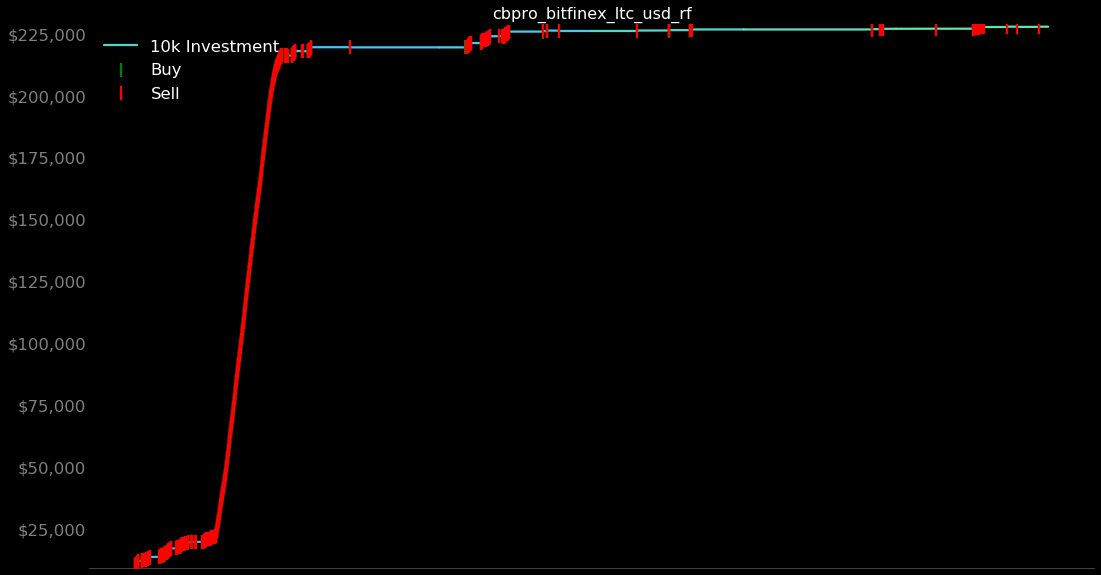

In [129]:
# testing viz 'bitfinex_cbpro_dash_btc'
arb_viz('cbpro_bitfinex_ltc_usd')

In [ ]:
arb_viz2('cbpro_bitfinex_ltc_usd')

In [ ]:
# pd.read_csv('data/arb_preds_test_data/cbpro_bitfinex_ltc_usd_rf.csv')

In [23]:
ALL_FEATURES = ['close_exchange_1','base_volume_exchange_1', 
                    'nan_ohlcv_exchange_1','volume_adi_exchange_1', 'volume_obv_exchange_1',
                    'volume_cmf_exchange_1', 'volume_fi_exchange_1','volume_em_exchange_1', 
                    'volume_vpt_exchange_1','volume_nvi_exchange_1', 'volatility_atr_exchange_1',
                    'volatility_bbhi_exchange_1','volatility_bbli_exchange_1', 
                    'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1',
                    'volatility_dchi_exchange_1','volatility_dcli_exchange_1',
                    'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 
                    'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 
                    'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 
                    'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 
                    'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 
                    'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1',
                    'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1',
                    'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1',
                    'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1',
                    'momentum_tsi_exchange_1', 'momentum_uo_exchange_1',
                    'momentum_stoch_signal_exchange_1', 'momentum_wr_exchange_1', 
                    'momentum_ao_exchange_1', 'others_dr_exchange_1', 'close_exchange_2',
                    'base_volume_exchange_2', 'nan_ohlcv_exchange_2',
                    'volume_adi_exchange_2', 'volume_obv_exchange_2',
                    'volume_cmf_exchange_2', 'volume_fi_exchange_2',
                    'volume_em_exchange_2', 'volume_vpt_exchange_2',
                    'volume_nvi_exchange_2', 'volatility_atr_exchange_2',
                    'volatility_bbhi_exchange_2', 'volatility_bbli_exchange_2',
                    'volatility_kchi_exchange_2', 'volatility_kcli_exchange_2',
                    'volatility_dchi_exchange_2', 'volatility_dcli_exchange_2',
                    'trend_macd_signal_exchange_2',
                    'trend_macd_diff_exchange_2', 'trend_adx_exchange_2',
                    'trend_adx_pos_exchange_2', 'trend_adx_neg_exchange_2',
                    'trend_vortex_ind_pos_exchange_2',
                    'trend_vortex_ind_neg_exchange_2',
                    'trend_vortex_diff_exchange_2', 'trend_trix_exchange_2',
                    'trend_mass_index_exchange_2', 'trend_cci_exchange_2',
                    'trend_dpo_exchange_2', 'trend_kst_sig_exchange_2',
                    'trend_kst_diff_exchange_2', 'trend_aroon_up_exchange_2',
                    'trend_aroon_down_exchange_2',
                    'trend_aroon_ind_exchange_2',
                    'momentum_rsi_exchange_2', 'momentum_mfi_exchange_2',
                    'momentum_tsi_exchange_2', 'momentum_uo_exchange_2',
                    'momentum_stoch_signal_exchange_2',
                    'momentum_wr_exchange_2', 'momentum_ao_exchange_2',
                    'others_dr_exchange_2', 'year', 'month', 'day',
                    'higher_closing_price', 'pct_higher', 
                    'arbitrage_opportunity', 'window_length']

In [24]:
print(ALL_FEATURES)

['close_exchange_1', 'base_volume_exchange_1', 'nan_ohlcv_exchange_1', 'volume_adi_exchange_1', 'volume_obv_exchange_1', 'volume_cmf_exchange_1', 'volume_fi_exchange_1', 'volume_em_exchange_1', 'volume_vpt_exchange_1', 'volume_nvi_exchange_1', 'volatility_atr_exchange_1', 'volatility_bbhi_exchange_1', 'volatility_bbli_exchange_1', 'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1', 'volatility_dchi_exchange_1', 'volatility_dcli_exchange_1', 'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1', 'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1', 'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1', 'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1'

In [35]:
pd.read_csv('model_perf-2.csv')

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,kraken_bitfinex_bch_btc_lr,kraken_bitfinex_bch_btc,lr,{},1.000000,NaN,NaN,NaN,0,0,0,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
1,kraken_gemini_eth_btc_lr,kraken_gemini_eth_btc,lr,{},0.996209,-0.20,-0.15,0.000760,0,0,0,0.000000,0.999240,0.000000,0.000000,0.996965,0.000000,0.000000,0.998101,0.000000
2,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
3,gemini_hitbtc_eth_btc_lr,gemini_hitbtc_eth_btc,lr,{},0.978059,NaN,NaN,0.021941,0,0,0,0.000000,0.978059,0.000000,0.000000,1.000000,0.000000,0.000000,0.988908,0.000000
4,bitfinex_kraken_etc_usd_lr,bitfinex_kraken_etc_usd,lr,{},0.022197,-0.24,-0.28,NaN,0,77,77,0.000000,0.000000,0.022197,0.000000,0.000000,1.000000,0.000000,0.000000,0.043429
5,cbpro_hitbtc_eos_btc_lr,cbpro_hitbtc_eos_btc,lr,{},0.999261,-0.61,-0.59,0.000000,0,0,0,0.000000,1.000000,NaN,0.000000,0.999261,NaN,0.000000,0.999631,NaN
6,kraken_cbpro_dash_btc_lr,kraken_cbpro_dash_btc,lr,{},0.002414,-0.39,-0.41,NaN,6,0,6,0.002414,0.000000,0.000000,1.000000,0.000000,0.000000,0.004817,0.000000,0.000000
7,bitfinex_gemini_bch_usd_lr,bitfinex_gemini_bch_usd,lr,{},0.995319,NaN,NaN,0.004681,0,0,0,0.000000,0.995319,NaN,0.000000,1.000000,NaN,0.000000,0.997654,NaN
8,cbpro_bitfinex_eth_usd_lr,cbpro_bitfinex_eth_usd,lr,{},0.168127,0.13,-0.22,0.000000,0,11030,11030,0.000000,1.000000,0.168115,0.000000,0.000018,1.000000,0.000000,0.000037,0.287839
9,gemini_hitbtc_ltc_btc_lr,gemini_hitbtc_ltc_btc,lr,{},0.867197,NaN,NaN,0.132803,0,0,0,0.000000,0.867197,0.000000,0.000000,1.000000,0.000000,0.000000,0.928876,0.000000
